In [3]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd

In [4]:
from torch.utils.data import Dataset, DataLoader

In [5]:
data = pd.read_csv('ACIW.csv')
data

,Date,Close,Volume
0,1995-02-24,2.979167,18890400
1,1995-02-27,3.041667,2052600
2,1995-02-28,2.979167,3112800
3,1995-03-01,3.041667,604200
4,1995-03-02,3.041667,244200
...,...,...,...
6315,2020-03-26,25.020000,1044800
6316,2020-03-27,23.170000,688700
6317,2020-03-30,23.610001,925300
6318,2020-03-31,24.150000,1471800


In [6]:
X = np.array(data['Close'])
lenX = X.size
X.shape, lenX

((6320,), 6320)

In [7]:
#Binary representation of my float ---> 1 bit sign 7 bit whole number, 16 bit decimal
X

array([ 2.97916675,  3.04166675,  2.97916675, ..., 23.61000061,
       24.14999962, 22.45999908])

In [8]:
class changeInXSeries():
    def __init__(self, X):
        self.X = X
        self.lenSeries = len(X)

        self.toRet = np.zeros_like(X)
        for i in range(0, self.lenSeries-1):
            self.toRet[i] = X[i+1] - X[i]

        self.toRet = torch.tensor(self.toRet, dtype=torch.float32)

    def __len__(self):
        return self.lenSeries-1
    
    def __getitem__(self, i):
        return self.toRet[i]
        

In [9]:
#check if the class works
changeInX = changeInXSeries(X)
count = 0
for i in range(0, lenX-1):
    if changeInX[i] != X[i+1] - X[i]:
        count += 1

print(count)

0


In [10]:
changeInX[0:10]

tensor([ 0.0625, -0.0625,  0.0625,  0.0000,  0.3125,  0.0833, -0.0625,  0.0000,
         0.0000, -0.0625])

In [11]:
class SeriestoBin():
    def __init__(self, X):
        self.X = X
        self.lenSeries = len(X)

        self.toRet = np.zeros((self.lenSeries, 24), dtype=int)
        self.toRet = self.convertToBin(X, self.toRet)

        self.toRet = torch.tensor(self.toRet, dtype = torch.float32)
    
    def convertToBin(self, X, toRet):
        for i in range(0, self.lenSeries):
            if float(X[i]) < 0:
                toRet[i][0] = 1
            
            xx = abs(X[i])
            exp = int(xx)
            dec = int((xx - exp)*(10**4))

            binExp = bin(exp)[2:]
            binDec = bin(dec)[2:]

            #padding
            for j in range(0, 7-len(binExp)):
                binExp = '0' + binExp
            for j in range(0, 16-len(binDec)):
                binDec = '0' + binDec
            
            print(toRet[i][0],binExp, binDec)

            for j in range(1, 8):
                toRet[i][j] = int(binExp[j-1])
            
            for j in range(8, 24):
                toRet[i][j] = int(binDec[j-8])
                
        
        return toRet
    
    def __len__(self):
        return self.lenSeries
    
    def __getitem__(self, i):
        return self.toRet[i]

In [12]:
#check if the class works
seriestoBin = SeriestoBin(changeInX)
# seriestoBin[0:10]

0 0000000 0000001001110001
1 0000000 0000001001110001
0 0000000 0000001001110001
0 0000000 0000000000000000
0 0000000 0000110000110101
0 0000000 0000001101000001
1 0000000 0000001001110001
0 0000000 0000000000000000
0 0000000 0000000000000000
1 0000000 0000001001110001
0 0000000 0000010011100010
1 0000000 0000001101000001
0 0000000 0000000110100000
1 0000000 0000000011010000
0 0000000 0000000000000000
1 0000000 0000000011010000
0 0000000 0000000011010000
1 0000000 0000010000010001
0 0000000 0000000011010000
0 0000000 0000000011010000
0 0000000 0000000000000000
0 0000000 0000011101010011
0 0000000 0000000000000000
0 0000000 0000001001110001
1 0000000 0000001101000001
0 0000000 0000000110100000
1 0000000 0000001000001000
1 0000000 0000001011011001
0 0000000 0000000000000000
0 0000000 0000000000000000
0 0000000 0000001001110001
0 0000000 0000000000000000
1 0000000 0000010011100010
0 0000000 0000000000000000
0 0000000 0000000000000000
1 0000000 0000001101000001
1 0000000 0000001101000001
1

In [13]:
changeInX[0:10]

tensor([ 0.0625, -0.0625,  0.0625,  0.0000,  0.3125,  0.0833, -0.0625,  0.0000,
         0.0000, -0.0625])

In [14]:
len(seriestoBin[0])

24

In [15]:
def convBack(X):
    sign = X[0]
    exp = 0
    dec = 0

    for j in range(1, 8):
        exp += int(X[j])*(2**(7-j))

    for j in range(8, 24):
        dec += int(X[j])*(2**(23-j))
    
    toRet = exp + dec/(10**4)

    if sign == 1:
        toRet = -toRet
    
    return toRet

In [16]:
for i in range(0, 10):
    print(convBack(seriestoBin[i]), changeInX[i])

0.0625 tensor(0.0625)
-0.0625 tensor(-0.0625)
0.0625 tensor(0.0625)
0.0 tensor(0.)
0.3125 tensor(0.3125)
0.0833 tensor(0.0833)
-0.0625 tensor(-0.0625)
0.0 tensor(0.)
0.0 tensor(0.)
-0.0625 tensor(-0.0625)


In [17]:
class TimeSeriesDataSet():
    def __init__(self, series, seqLen):
        self.series = series
        self.seqLen = seqLen

    def numNeg(self):
        count = 0
        for i in range(0, len(self.series)):
            if self.series[i][0] == 1:
                count += 1
        return count
    
    def __len__(self):
        return len(self.series) - self.seqLen
    
    def __getitem__(self, i):
        return self.series[i:i+self.seqLen]

In [18]:
#check if the class works
timeSeriesDataSet = TimeSeriesDataSet(seriestoBin, 10)
count = 0
for i in range(0, len(timeSeriesDataSet)):
    if torch.equal(timeSeriesDataSet[i], seriestoBin[i:i+10]) == False:
        count += 1

count

0

In [19]:
import matplotlib.pyplot as plt

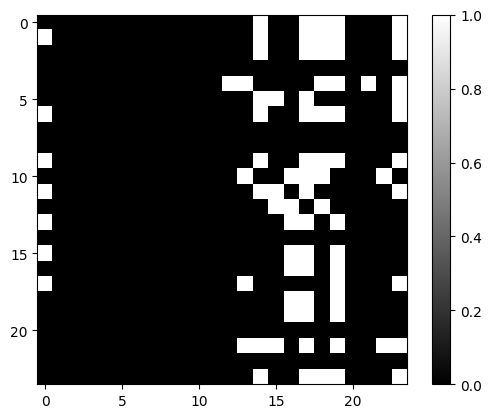

In [20]:
matrix = seriestoBin[0:24].numpy()

# Generate the image
plt.imshow(matrix, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

In [21]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        #N*1*24*24
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        #N*32*22*22
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        #N*32*11*11
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding = 1)
        #N*64*8*8
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        #N*64*4*4
        self.flatten = nn.Flatten()
        #N*1024
        self.fc1 = nn.Linear(1600, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)
        self.fc4 = nn.Linear(100, 24)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool2(nn.ReLU()(self.conv2(x)))
        x = self.flatten(x)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        x = nn.Sigmoid()(self.fc4(x))
        return x

lenet = LeNet()

In [ ]:
#Hyperparameters
timeLen = 25
epochs = 100
batchSize = 12
lr = 0.001

dataset = TimeSeriesDataSet(seriestoBin, timeLen)
dataloader = DataLoader(dataset, batch_size = batchSize, shuffle = False)

In [23]:
loss = nn.BCELoss()
optimizer2 = torch.optim.Adam(lenet.parameters(), lr = lr)

In [24]:
import sys

In [25]:
count0 = 0
count1 = 0
for i in range(0, len(X)-1):
    if X[i+1] - X[i] < 0:
        count1 += 1
    else:
        count0 += 1

threshPosNeg = count0/(count1+count0)
count0, count1, threshPosNeg, count1/count0

(3321, 2998, 0.5255578414306061, 0.9027401385124962)

In [26]:
def applyThreshold(x):
    for i in range(0, len(x)):
        if i == 0:
            if x[i] > threshPosNeg:
                x[i] = 1
            else:
                x[i] = 0
            continue
        if x[i] > 0.5:
            x[i] = 1
        else:
            x[i] = 0
    return x

In [27]:
for i in range(epochs):
    total_err = 0
    for it, sequences in enumerate(dataloader):
        optimizer2.zero_grad()
        price_history = sequences[:, :-1]
        target = sequences[:, -1]
        
        

        y = lenet(price_history.unsqueeze(1))
        
        # if i == epochs - 1:
        #     print(price_history.shape, target.shape)
        #     print(target.shape)
        #     # print(target)
        #     # for i in range(0, len(y)):
        #     #     k = convBack(target[i])
        #     #     print(k)
        #     print("---------------")
        #     # print(model(price_history)[0])
        #     print("---------------")
        #     for j in range(0, len(y)):
        #         k = applyThreshold(y[j])
        #         k = convBack(k)
        #         print(convBack(target[j])," - ",k)
        #     sys.exit()

        err = loss(y, target)

                   
        err.backward()
        optimizer2.step()
        total_err += err.item()
        # if it == 0 or len(dataloader) - it == 1:
        #     print("At iteration: ", it)
        #     for name, param in model.named_parameters():
        #         if param.grad is not None:
        #             print(f"{name} grad norm: {param.grad.norm().item()}")
        #         else:
        #             print(f"{name} grad norm: {param.grad}")
    
    print(f'Epoch {i+1} Loss: {total_err/len(dataloader)}')

Epoch 1 Loss: 0.39088822972206844
Epoch 2 Loss: 0.38552595314525423
Epoch 3 Loss: 0.38557900167646864
Epoch 4 Loss: 0.3855215308212099
Epoch 5 Loss: 0.3852424944014776
Epoch 6 Loss: 0.38506677712712967
Epoch 7 Loss: 0.3841400983220055
Epoch 8 Loss: 0.38373961857386996
Epoch 9 Loss: 0.3823478409222194
Epoch 10 Loss: 0.3800641976084028
Epoch 11 Loss: 0.37744696338971456
Epoch 12 Loss: 0.37423567578906103
Epoch 13 Loss: 0.3703263298670451
Epoch 14 Loss: 0.36676778049696057
Epoch 15 Loss: 0.3623132614294688
Epoch 16 Loss: 0.3574568899188723
Epoch 17 Loss: 0.3497694666612716
Epoch 18 Loss: 0.3437375011330559
Epoch 19 Loss: 0.33719434670039583
Epoch 20 Loss: 0.3294778586285455
Epoch 21 Loss: 0.32041623166629246
Epoch 22 Loss: 0.3140825033471698
Epoch 23 Loss: 0.3033990312757946
Epoch 24 Loss: 0.2935839471362886
Epoch 25 Loss: 0.2840448108173552
Epoch 26 Loss: 0.2698842392365138
Epoch 27 Loss: 0.2594404457296644
Epoch 28 Loss: 0.24959993359588442
Epoch 29 Loss: 0.23345235369035175
Epoch 30 Lo

In [28]:
with torch.no_grad():
    count = 0
    countOther = 0
    cc = 0
    predictions, errors = torch.tensor([]), torch.tensor([])
    for i in range(len(dataset)):
        sequence = dataset[i]
        past, price_gt = sequence[:-1], sequence[-1]

        # if i == 0:
        #     print(past.shape, price_gt.shape)

        #     sys.exit()

        past = past.unsqueeze(0)
        price_pred = lenet(past.unsqueeze(0))
        save = price_pred
        past = past.squeeze(0)
        price_pred = price_pred.squeeze(0)

        pthresh = applyThreshold(price_pred)          
        
        if price_gt[0] == 1:
            cc += 1

        if convBack(price_gt) < 0:
            p = convBack(pthresh)
            if p > 0: #Misclassification
                count += 1
                # print(lenet(past.unsqueeze(0).unsqueeze(0)).squeeze(0))
                # print(p, " - ", convBack(price_gt))
            else: #Correct classification
                countOther += 1
                # if countOther < 3:
                #     print("------------------------")
                #     print(lenet(past.unsqueeze(0).unsqueeze(0)).squeeze(0))
                #     print(p, " - ", convBack(price_gt))
                #     print("+++++++++++++++++++++++++++++")
            # print(p, " - ", convBack(price_gt))

        if predictions.size(0) == 0:
            predictions = torch.tensor([convBack(pthresh)])
        else:
            predictions = torch.cat((predictions, torch.tensor([convBack(pthresh)])), dim = 0)

In [29]:
predictions

tensor([-0.0833,  0.0384, -0.0520,  ..., -1.8500,  0.4400,  0.5399])

In [30]:
count, countOther, len(dataset), cc

(129, 2861, 6294, 2990)

In [31]:
dataset.numNeg()

2998

In [32]:
predictions2 = predictions.tolist()
len(predictions2)

6294

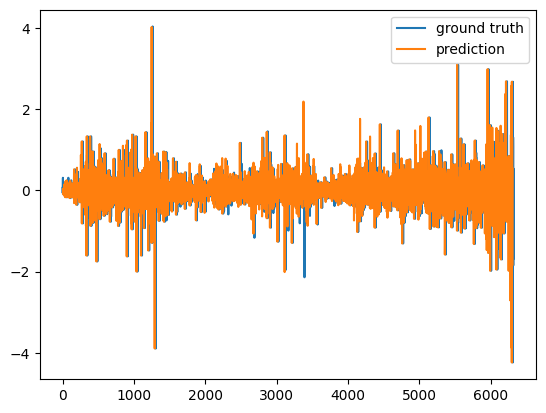

In [33]:
plt.plot(changeInX, label='ground truth')
plt.plot([None]*10+predictions2, label='prediction')

plt.legend()
plt.show()

In [34]:
preds = []
for i in range(timeLen, len(predictions2)):
    preds.append(X[i-1] + predictions2[i-timeLen])

len(preds)

6269

In [35]:
len(X), len(predictions2)

(6320, 6294)

In [36]:
toShow = np.array(preds) + 5 #Offset for better visualization

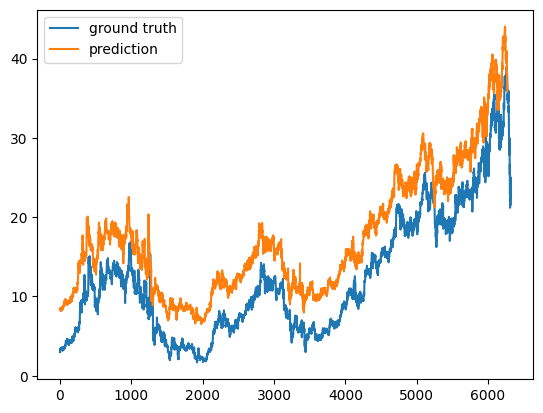

In [37]:
plt.close()
plt.plot(X, label='ground truth')
plt.plot(toShow, label='prediction')

plt.legend()
plt.show()

In [38]:
#Let the generation run wild after the first sequence
datasetWild = TimeSeriesDataSet(seriestoBin, 24)
with torch.no_grad():
    predictionsWild, errorsWild = torch.tensor([]), torch.tensor([])
    init = datasetWild[0]
    for i in range(6000):
        pred = lenet(init.unsqueeze(0).unsqueeze(0))

        init = init[1:]

        pred = pred.squeeze(0)
        predThresh = applyThreshold(pred)

        # print(init.shape)

        init = torch.cat((init, predThresh.unsqueeze(0)), dim = 0)
        
        # print(init)
        # print(convBack(datasetWild[1][0]))
        # print(predThresh)
        # print(convBack(predThresh))
        # sys.exit()

        toAppend = convBack(predThresh)
        if predictionsWild.size(0) == 0:
            predictionsWild = torch.tensor([toAppend])
        else:
            predictionsWild = torch.cat((predictionsWild, torch.tensor([toAppend])), dim = 0)



In [39]:
predictionsWild.shape

torch.Size([6000])

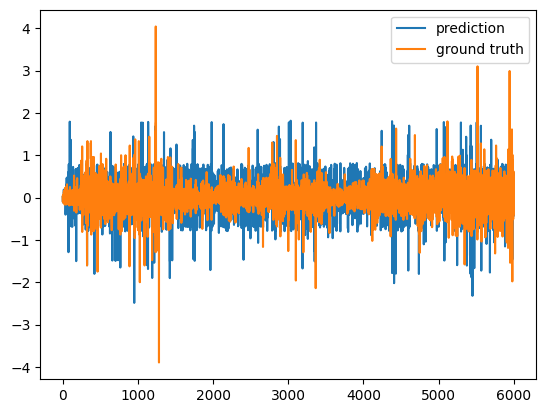

In [40]:
plt.close()
plt.plot(predictionsWild, label='prediction')
plt.plot(changeInX[24:6000+24], label='ground truth')   

plt.legend()
plt.show()

In [41]:
predsReal = []
for i in range(24, len(predictionsWild)):
    if i == 24:
        predsReal.append(X[i] + predictionsWild[i-24])
    else:
        predsReal.append(predsReal[-1] + predictionsWild[i-24])

len(predsReal)

5976

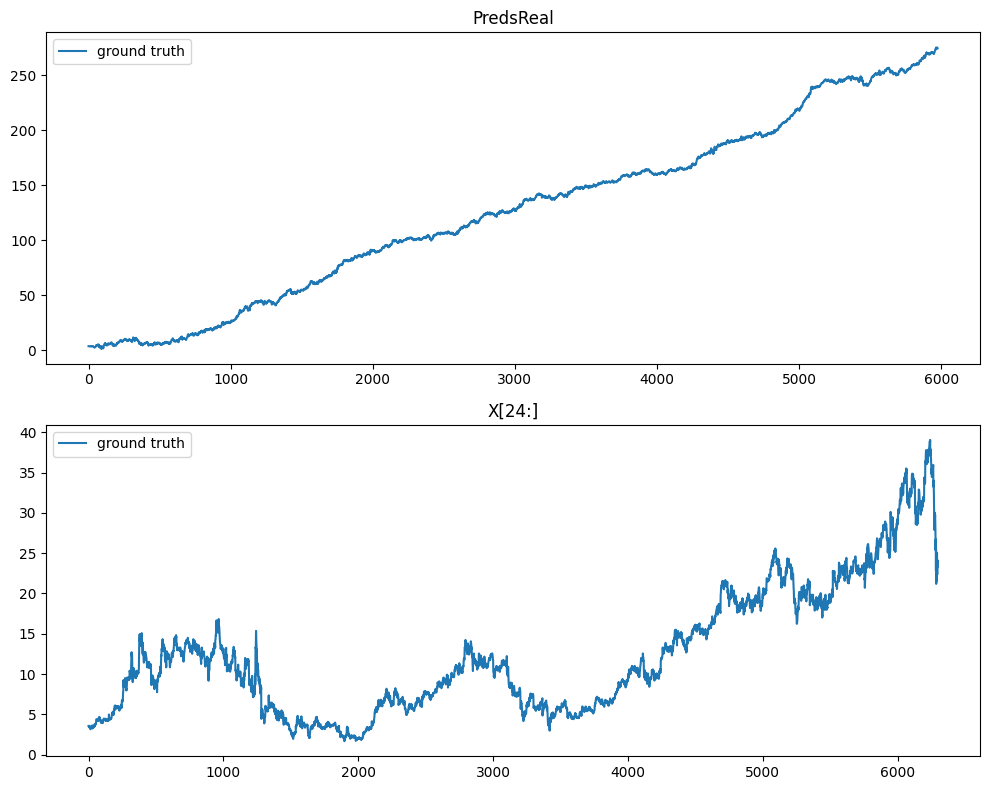

In [42]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(predsReal, label='ground truth')
axs[0].set_title('PredsReal')
axs[0].legend()

# Second subplot
axs[1].plot(X[24:], label='ground truth')
axs[1].set_title('X[24:]')
axs[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [67]:
len(seriestoBin), int(0.8*len(seriestoBin))


(6319, 5055)

In [68]:
train = seriestoBin[:int(0.8*len(seriestoBin))]
test = seriestoBin[int(0.8*len(seriestoBin)):]
trainDataset = TimeSeriesDataSet(train, 25)
testDataset = TimeSeriesDataSet(test, 25)

trainDataloader = DataLoader(trainDataset, batch_size = 12, shuffle = True)

In [69]:
model_new = LeNet()
optimizer = torch.optim.Adam(model_new.parameters(), lr = 0.001)
loss = nn.BCELoss()

In [70]:
for i in range(100):
    total_err = 0
    for it, sequences in enumerate(trainDataloader):
        optimizer.zero_grad()
        price_history = sequences[:, :-1]
        target = sequences[:, -1]
        y = model_new(price_history.unsqueeze(1))
        err = loss(y, target)
        err.backward()
        optimizer.step()
        total_err += err.item()
    print(f'Epoch {i+1} Loss: {total_err/len(trainDataloader)}')

Epoch 1 Loss: 0.38878272019681476
Epoch 2 Loss: 0.3787038984043258
Epoch 3 Loss: 0.3751298838428089
Epoch 4 Loss: 0.374363594963437
Epoch 5 Loss: 0.3731798848225957
Epoch 6 Loss: 0.37234789289179304
Epoch 7 Loss: 0.37160231201421645
Epoch 8 Loss: 0.3708459358130183
Epoch 9 Loss: 0.36946432008629754
Epoch 10 Loss: 0.36844333353496733
Epoch 11 Loss: 0.36669812592722123
Epoch 12 Loss: 0.36478886760416485
Epoch 13 Loss: 0.36237805507012777
Epoch 14 Loss: 0.36018657726900916
Epoch 15 Loss: 0.3575885221362114
Epoch 16 Loss: 0.3545114190805526
Epoch 17 Loss: 0.35135526124920163
Epoch 18 Loss: 0.3471930488234475
Epoch 19 Loss: 0.3441588336513156
Epoch 20 Loss: 0.338296658936001
Epoch 21 Loss: 0.3333848707023121
Epoch 22 Loss: 0.32624059227250873
Epoch 23 Loss: 0.31948152021283194
Epoch 24 Loss: 0.3125510026656446
Epoch 25 Loss: 0.30287568327926456
Epoch 26 Loss: 0.29422792934236075
Epoch 27 Loss: 0.28393629555191313
Epoch 28 Loss: 0.2732720345968292
Epoch 29 Loss: 0.26331194954968634
Epoch 30 

In [71]:
pred_new = []
with torch.no_grad():
    for i in range(0, len(testDataset)):
        price_history = testDataset[i][:-1]
        target = testDataset[i][-1]
        y = model_new(price_history.unsqueeze(0).unsqueeze(0)).squeeze(0)
        pred_new.append(convBack(applyThreshold(y)))
        err = loss(y, target)
        print(f'Batch {it} Loss: {err.item()}')
    

Batch 419 Loss: 33.33333206176758
Batch 419 Loss: 12.5
Batch 419 Loss: 16.66666603088379
Batch 419 Loss: 25.0
Batch 419 Loss: 20.83333396911621
Batch 419 Loss: 41.66666793823242
Batch 419 Loss: 12.5
Batch 419 Loss: 29.16666603088379
Batch 419 Loss: 29.16666603088379
Batch 419 Loss: 25.0
Batch 419 Loss: 20.83333396911621
Batch 419 Loss: 16.66666603088379
Batch 419 Loss: 29.16666603088379
Batch 419 Loss: 20.83333396911621
Batch 419 Loss: 33.33333206176758
Batch 419 Loss: 20.83333396911621
Batch 419 Loss: 29.16666603088379
Batch 419 Loss: 37.5
Batch 419 Loss: 20.83333396911621
Batch 419 Loss: 33.33333206176758
Batch 419 Loss: 25.0
Batch 419 Loss: 41.66666793823242
Batch 419 Loss: 25.0
Batch 419 Loss: 29.16666603088379
Batch 419 Loss: 20.83333396911621
Batch 419 Loss: 25.0
Batch 419 Loss: 20.83333396911621
Batch 419 Loss: 29.16666603088379
Batch 419 Loss: 25.0
Batch 419 Loss: 20.83333396911621
Batch 419 Loss: 25.0
Batch 419 Loss: 33.33333206176758
Batch 419 Loss: 29.16666603088379
Batch 41

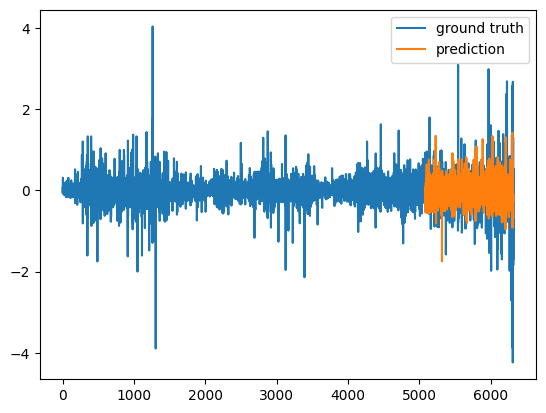

In [72]:
plt.close()
plt.plot(changeInX, label='ground truth')
plt.plot([None]*(len(changeInX) - len(pred_new)) + pred_new, label='prediction')
plt.legend()
plt.show()

In [73]:
ground_preds = [] 
for i in range(0, len(pred_new)-1):
    if i == 0:
        ground_preds.append(X[i+24] + pred_new[i])
    else:
        ground_preds.append(ground_preds[-1] + pred_new[i])

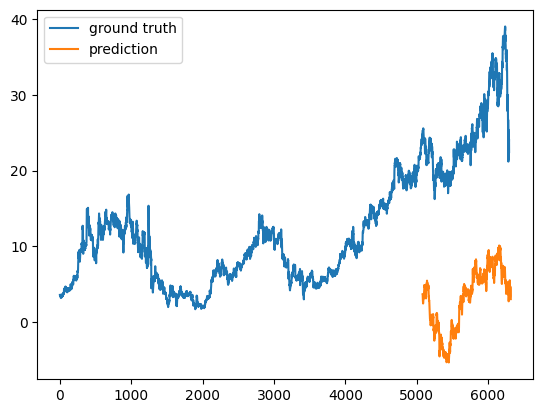

In [ ]:
plt.close()
plt.plot(X[24:], label='ground truth')
plt.plot([None]*(len(X) - len(ground_preds)) + ground_preds, label='prediction')

plt.legend()
plt.show()

Value has been offset by quite a lot because I used the value at 25th index to start adding the change instead of the corresponding value. Makes it easier to see the graph tho